In [ ]:
#
# Run this cell to set up
#

import requests
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
from datetime import datetime
import seaborn as sns
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta
import re
import os
from os.path import join, abspath, dirname, exists

base_url = 'https://andresvidal.github.io/speedtracker-jet'
data_path = join(os.getcwd(), 'wpt_data')
temp_path = join(os.getcwd(), 'wpt_temp')

#### GET DATA ################################

def get_speedtracker_tests(profile_slug):
    data = requests.get(f'{base_url}/profiles.json').json()
    st_tests = {}
    for i, profile in enumerate(data):
        st_tests[profile['slug']] = []
        for test in profile['tests']:
            date = str(test)
            r_json = f"{base_url}/results/{profile['slug']}/{date[:4]}/{date[-2:]}.json"
            st_tests[profile['slug']].append(r_json)
    return st_tests[profile_slug]

def get_speedtracker_wpt_ids(speedtracker_tests):
    wpt_ids = []
    for test in speedtracker_tests:
        t = requests.get(test)
        data = t.json()
        wpt_ids = wpt_ids + data['_r']['id']
    return wpt_ids

def get_wpt_tests(wpt_ids, slug='test', save=True):
    csv_file = join(data_path, f"{slug}.csv")
    
    # Load csv if exists
    try:
        wpt_df = pd.read_csv(csv_file, index_col=None)
        tests_exist = wpt_df['data.id'].tolist()
        collection = [wpt_df]
    except FileNotFoundError:
        tests_exist = []
        collection = []
    
    for test in wpt_ids:
        print(f"Checking {test}")
        if test not in tests_exist:
            print(f"fetching {test}")
            wpt = requests.get(f'https://www.webpagetest.org/result/{test}/?f=json').json()
            try:
                # del large data keys
                delkeys = ['median', 'lighthouse', 'runs', 'standardDeviation']
                for key in delkeys:
                    if key in wpt['data'].keys():
                        del wpt['data'][key]

                ts = wpt['data']['completed']
                wpt['speedtracker.slug'] = slug
                wpt['speedtracker.year'] = datetime.fromtimestamp(ts).strftime('%Y')
                wpt['speedtracker.month'] = datetime.fromtimestamp(ts).strftime('%m')
                wpt['speedtracker.day'] = datetime.fromtimestamp(ts).strftime('%d')
                wpt['speedtracker.week'] = datetime.fromtimestamp(ts).isocalendar()[1]

                # flatten JSON
                collection.append( json_normalize(wpt) )
            except Exception as e:
                statusText = wpt.get('statusText', e)
                print('get_wpt_tests exception:', statusText)

    wpt_df = pd.concat(collection).drop_duplicates(subset='data.id', inplace=False).reset_index(drop=True)
    
    if save:
        if not exists(data_path):
            os.makedirs(data_path)
            print("Created Directory " , data_path)
        
        print(f"Saving: {csv_file}")
        wpt_df.to_csv(csv_file, index=False)
        
    return wpt_df


def get_wpt_from_speedtracker_tests(profile_slug, save=True):
    speedtracker_tests = get_speedtracker_tests(profile_slug)
    wpt_ids = get_speedtracker_wpt_ids(speedtracker_tests)
    get_wpt_tests(wpt_ids, slug=profile_slug, save=save)
    
#### PARSE DATA ################################

def get_pagetype(profile_slug):
    '''Pagetype regex for Jet profiles only. like: browse22 = browse'''
    pagetype = re.search(r'([a-z]+)', profile_slug)
    if pagetype:
        pagetype = pagetype.group(0)
    return pagetype

def compare(before, after, profile_slug='', fromdates='', todates=''):
    data = {}
    for item in after:
        data[item] = {}
        data[item][f'{profile_slug} {fromdates} (before - avg)'] = before[item]
        data[item][f'{profile_slug} {todates} (after - avg)'] = after[item]
        #data[item][f'{profile_slug} delta (seconds)'] = after[item] - before[item]
        data[item][f'{profile_slug} delta %'] = round(((after[item] - before[item])/before[item])*100, 2)
    return data

def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    
    # Carefull... returns full df but filters out outlier rows only
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

def validate_outliers(df, col_name, start_date=None, end_date=None):
    if start_date and end_date:
        df['date'] = pd.to_datetime(df['data.completed'], unit='s') 
        mask = (df['date'] > parse(start_date)) & (df['date'] <= parse(end_date))
        df = df[mask]

    sns.boxplot(df[col_name])

def mean(profile_slug, start_date, end_date, counts=False):
    csv_file = join(data_path, f"{profile_slug}.csv")
    
    # Choose metrics to include in average calculations
    metrics  = ['data.average.firstView.TTFB', 
                
                'data.average.firstView.firstPaint',
                #'data.average.firstView.PerformancePaintTiming.first-paint',
                
                'data.average.firstView.firstContentfulPaint',
                #'data.average.firstView.PerformancePaintTiming.first-contentful-paint',
                #'data.average.firstView.chromeUserTiming.firstContentfulPaint',
                
                'data.average.firstView.firstMeaningfulPaint',
                
                'data.average.firstView.FirstInteractive',
                'data.average.firstView.TimeToInteractive',
                'data.average.firstView.domInteractive',
                #'data.average.firstView.LastInteractive',
                
                'data.average.firstView.SpeedIndex',
                'data.average.firstView.fullyLoaded',
                ]
    
    df = pd.read_csv(csv_file)
    df['date'] = pd.to_datetime(df['data.completed'], unit='s') 
    
    #adding 1 day assumes comparison with top of the previous day. Note: exact end_date with hours will not work.
    mask = (df['date'] > parse(start_date)) & (df['date'] < parse(end_date)+relativedelta(days=+1))
    df = df[mask]
    
    dfo = {}
    for metric in metrics:
        # remove outliers and get mean per metric.
        dfo[metric] = round(remove_outlier(df, metric)[metric].mean() / 1000, 3) # seconds
        #print(f'{profile_slug} {metric} {dfo[metric]}')
        if counts:
            dfo[f'{metric}_count'] = df[metric].count()
    
    return dfo
    #return df
    
def run_compare(profile_slugs, from_start, from_end, to_start, to_end):
    collection = []
    from_date_range = f"{from_start}_{from_end}"
    to_date_range = f"{to_start}_{to_end}"
    
    if type(profile_slugs) == str:
        profile_slugs = [profile_slugs]
    
    for profile_slug in profile_slugs:
        before = mean(profile_slug, from_start, from_end)
        after = mean(profile_slug, to_start, to_end)

        # times will be in seconds
        results = compare(before, after, profile_slug, from_date_range, to_date_range)
        collection.append(pd.DataFrame( results ) )

    return pd.concat(collection)

In [10]:
import json
t = {
  "data": {
    "statusCode": 400,
    "statusText": "Test not found",
    "id": "181229_PN_5d6caab3b2a1da796652be55e7277447"
  },
  "statusCode": 400,
  "statusText": "Test not found"
}

t.get('statusText1', 'hello')

'hello'

In [12]:
#
# Run this cell to download the following profile data from webpagetest as csv files
# See first cell to update: data_path = path
# Run first cell again if modified
#

speedtracker_profiles_download = [
 'home',
 'home-noanalytics',
 'product22',
 'product2',
 'product2-noanalytics',
 'product24',
 'product25',
 'product27',
 'browse22',
 'browse24',
 'browse26',
 'search',
 'search23',
 'search26',
 'walmart-home',
 'target-home',
 'nike-home',
 'amazon-home',
 'bhphoto-home',
 'bhphoto-browse',
 'bhphoto-product',
 'bhphoto-search']

for profile in speedtracker_profiles_download:
    get_wpt_from_speedtracker_tests(profile)

Checking 181027_F6_56a4c838817a4adcc9e62322acbc796d
Checking 181027_SZ_6b0e130db64f885d8a8e1d09ad091776
Checking 181027_1D_7f23d9d3e66756bc6af56b3205a82d7e
Checking 181027_NM_4e5a09b4ba227d7ef39a813dd74fd270
Checking 181027_SB_2cb93473648572a87ff1200a5f63e605
Checking 181027_6Z_69df3e26e151cb3dd2fb01007b5326c7
Checking 181028_RH_fc78df873f575022a249e1d75730c7a9
Checking 181028_B4_56ecd52e36503b579ad1fac10eaaf73b
Checking 181028_EW_87ba8e00ee13a3c1ee8c56c11e65e2dd
Checking 181028_CV_3d6fb4f17c72ef74f825ad5c58345b31
Checking 181028_SV_c95cd8975704463c26bbad7890d52626
Checking 181028_VZ_71243e20d4ce74eb3717bf483c420d6c
Checking 181028_GM_55b7580fe4778352a464b755c9a3a927
Checking 181029_7B_891959087bab0f528f816d569aa789e3
Checking 181029_70_7fbbd3d299ba6aae3706534bd5ae4978
Checking 181029_WQ_a65ea1bb2d5f343bd4215f826f78f3e3
Checking 181029_19_a89aebe8db942ab2c883ee9db6bdc8d6
Checking 181029_WF_e2fe26a020d723ca600faf4944fc2b43
Checking 181030_15_2412fccfc6bdd9dc813aa4e5ecee92e2
Checking 181

Checking 190103_25_4349e3d22539211cb3a49d91161ba24f
fetching 190103_25_4349e3d22539211cb3a49d91161ba24f
get_wpt_tests Exception: Test not found
Checking 190103_G6_12672d17e97bfe9b7bdc5f9cb53a3fa5
fetching 190103_G6_12672d17e97bfe9b7bdc5f9cb53a3fa5
get_wpt_tests Exception: Test not found
Checking 190104_JJ_c0b640d686ca2c4cbe712910730f37be
fetching 190104_JJ_c0b640d686ca2c4cbe712910730f37be
get_wpt_tests Exception: Test not found
Checking 190104_H0_c5c225e3ef78ecfbbbca8b1cfb2642c7
fetching 190104_H0_c5c225e3ef78ecfbbbca8b1cfb2642c7
get_wpt_tests Exception: Test not found
Checking 190105_48_5aa11601c9477252cef31cc0455dc11f
fetching 190105_48_5aa11601c9477252cef31cc0455dc11f
get_wpt_tests Exception: Test not found
Checking 190105_AA_f4542017d83c1b70b4506977eefb1d6b
fetching 190105_AA_f4542017d83c1b70b4506977eefb1d6b
get_wpt_tests Exception: Test not found
Checking 190106_42_50129dcaccf7a06fcbf977f31be56e7c
fetching 190106_42_50129dcaccf7a06fcbf977f31be56e7c
get_wpt_tests Exception: Test no

Saving: /Users/andres.vidal/Downloads/speedtracker-jet/wpt_data/home-noanalytics.csv
Checking 181028_D3_3e5d6841e8fd10e8bbe2b756346ec314
Checking 181028_CJ_8f9de0ec67d6675047d38dbea98177c4
Checking 181028_NZ_d94468097edd271acce7efa326a2903c
Checking 181028_7K_f5800090285d858680753c3a7d502271
Checking 181028_8J_607dc21dd7e492853f46ef8f0b36d768
Checking 181028_2T_1ec0768f395a364ab9541ac6d663f1ed
Checking 181028_38_e7bf12f749af1b9bdfdc10eeee22b0aa
Checking 181029_NJ_543cf3f45478bf8cd6cc984b562b3cd7
Checking 181029_PE_7cf63350ec15b78602eb1bc733924de0
Checking 181029_N0_2c89fb14816d3c11e3b3fab0dae0dea3
Checking 181029_6C_44c5a54cd5c94e5b47662d3ee1f55dea
Checking 181029_6A_85ec8491264dd4a8dce3aa97c6310123
Checking 181029_MH_494795f9f77690cd637f42da38557cba
Checking 181029_EX_bddcf614ed52d6f42331ba4cc53adc0a
Checking 181030_7D_34256065bb21918d86f56eeb894606e1
Checking 181030_WQ_4e23199f1e8953c0963ef6e30b21f184
Checking 181030_1X_e095a4febe65cb8bb6a0b32bf519a462
Checking 181030_Q4_28a21f6e47d0

Checking 181028_NE_f3f889441ce1e0607c04fd5ac32405bd
Checking 181028_S7_c21f57ee792bdfe191765445e97da2c3
Checking 181028_PC_d6eff2e1dd9ac39008ba1bd30a51c7c6
Checking 181028_DT_cf759e67ebc522eb2a6e25bb50b034ce
Checking 181028_8K_589932d7f2d19705296d748e3f129e63
Checking 181028_CN_1c305333204330ee5537d2df24b30212
Checking 181029_N5_cf50ba5fe4721822d93e8f27ff3d06de
Checking 181029_KV_c735b86a083cdedc520d4b3d66a2fee5
Checking 181029_NZ_0af08f9aa855f220435500e6d1cd755e
Checking 181029_ST_9bca524e39f1fb8394761e13e6f0766c
Checking 181029_QN_b643a88fff74b7f1fe38628ee6d68d2b
Checking 181029_MX_fc19abe1ce92ba340cda70a024566840
Checking 181030_JY_ffcdb5dc74eab85a9a3dc618e7ee093f
Checking 181030_K3_14b0cd7ab27797b7e04b90d01a388864
Checking 181030_ST_52483d6d0908ea06f33174c36e242257
Checking 181031_GK_6846bc67cd095cbcc1d3ebfd97acce8c
Checking 181101_87_781553db3e337f8cff68515134708c51
Checking 181101_DA_889ba8cfcd3e3d69cacc2bab6a482610
Checking 181102_A2_1562c3e90106db57ae39d0cccd2cc680
Checking 181

Checking 190103_6T_086d725f662504e8932751ee77f434a1
fetching 190103_6T_086d725f662504e8932751ee77f434a1
get_wpt_tests Exception: Test not found
Checking 190103_D7_e633d750f3acba6cd770dbdfa2c4c18c
fetching 190103_D7_e633d750f3acba6cd770dbdfa2c4c18c
get_wpt_tests Exception: Test not found
Checking 190104_TW_913a709b4d4ccf4d3931b34bb9943d0e
fetching 190104_TW_913a709b4d4ccf4d3931b34bb9943d0e
get_wpt_tests Exception: Test not found
Checking 190104_P9_56b7720abcb1f60a20a62e3329a030ed
fetching 190104_P9_56b7720abcb1f60a20a62e3329a030ed
get_wpt_tests Exception: Test not found
Checking 190105_FF_c995bbb457782dd87379073de8f66035
fetching 190105_FF_c995bbb457782dd87379073de8f66035
get_wpt_tests Exception: Test not found
Checking 190105_AX_10af5d99fb2979fd54e7d3495c7e51af
fetching 190105_AX_10af5d99fb2979fd54e7d3495c7e51af
get_wpt_tests Exception: Test not found
Checking 190106_4W_a4e8b8ceb293491af199f8331065b81b
fetching 190106_4W_a4e8b8ceb293491af199f8331065b81b
get_wpt_tests Exception: Test no

Checking 181028_GC_c8b611bacec5eac4e561d562d5287060
Checking 181028_Z7_9b64c25142c10d88591dcaf68a57bf14
Checking 181028_B6_f70060a8ff758a4aeea6ce5278e96be6
Checking 181028_K8_2b01852bc5334e8f2074e4e88e92850b
Checking 181028_0T_6ab02b723f632ed2ba94c7d8febf7c90
Checking 181029_R4_dd77f5322d7729138f864fd86163d96d
Checking 181029_ZE_40be2056a3b8ea68c4789b39a6db5923
Checking 181029_1W_c223c91f24b217b1c1aeab6492d5d0b2
Checking 181029_W0_a6c5deddeb6b2287d125cc951cea0eaf
Checking 181030_AH_1a2df5d44f1c833dcea4f2027af51eb2
Checking 181030_TZ_d7529e5d6c7240d07bb1a61abf594aae
Checking 181030_YP_6e86c4d4817ef88d89d471eb8f07dfe5
Checking 181031_12_84c54d323505495fb5ee26f62a67e2f0
Checking 181031_4P_4c2004675e1dc7863247a065f7ed2b2c
Checking 181031_N1_fb3b6c67cef9be78a4af64de6856da43
Checking 181101_5R_cf2f9d5fc7ce30bbdbd9e9111d9532d7
Checking 181101_JN_36854bd7d437a2c6719cc17fc2d6375a
Checking 181103_86_ea0f3dc069d0e38a545d6c1d21343c79
Checking 181103_NQ_47c36a0f7430a668342ba289f2166790
Checking 181

Checking 181028_1S_781d1682592e746810823ce4b62b24a5
Checking 181028_FA_0d10cf201be7ebbd349fa64887214111
Checking 181028_1S_c2acafefcc1ca9c148406c8600937e80
Checking 181028_MM_93e6014525af9466c99fa686e02dd30c
Checking 181028_NB_19eafde076985571b16bb2dfe6f96d50
Checking 181028_88_51e410e7743c32b402578d18c0033f42
Checking 181029_FM_f10f0b29f054782752ff59b88e0b59c7
Checking 181029_VP_ab5f11b7e85c5eaa790aa1f3e7199005
Checking 181029_JC_640352a5aad89e037906a7190af17b2e
Checking 181029_74_67b35eb73f3c34e16e743508d8eb50aa
Checking 181029_WN_b82ebf4399963324c55075d6223ea03c
Checking 181030_P8_d5d5749cdfd71fd7e94f95d75a3cfe5c
Checking 181030_CT_baedbafa0245bb97fe616cdb135dde51
Checking 181030_NR_2666891fa97f8c5bf3df572337fe4cd4
Checking 181030_1N_66b27f20f14ccaae734c5f6033d568fb
Checking 181031_0P_42def10dd3075533463261521ff9ca04
Checking 181031_9S_31590b40314cb9776dc833473447ee40
Checking 181101_MF_20744c03c7e2dbf65023d5360f4ca3a7
Checking 181102_18_35f02a3df7866c5a78ccbf1df3007416
Checking 181

Checking 181028_BS_3e3cff55fcb1f381d5d9fa304e288c17
Checking 181028_6P_b76bd50259dbb43f49858fc5c7b6bec2
Checking 181028_JA_c626a978af62a85f985f95e3469ea3a0
Checking 181028_ZD_8928357e45aad56283e51dbfb0fc59fd
Checking 181028_W4_1a99318ec34df92ce4a77c1736631e19
Checking 181028_KC_70b5c3da5326fa395ac59e4c8097ca8f
Checking 181028_XZ_ff56eed6cf31a5afef3635f2d30ac984
Checking 181029_F5_31f84644c268a2f1df4e18d2b3d832b2
Checking 181029_ZJ_bf4594ead590e7a770dbef539e66f4fe
Checking 181029_TY_0165652e0fe0743b39034b7b82eb0f72
Checking 181029_EK_d5b3e3c0f3a1057f5922e054509e18ce
Checking 181029_VQ_a905da1cd2bda4f11e2b5043397a5b58
Checking 181029_8J_206670d1ff7538b74081a0a42581bd5d
Checking 181030_NC_5bc69a1d57b07f819f9e2e06d9c354d8
Checking 181030_3C_9c38826bfa0a42ccfa263a4c5f7785af
Checking 181030_KK_2c947c61b3fd171ce4f521f1eda9a86a
Checking 181030_QW_b3927665328a11fc0d05c2d4a2f42ced
Checking 181031_5V_859f68b067b196b1c82bcba2e10da6c9
Checking 181031_N9_e50cb7e8564974d1ef5a48398947c51c
Checking 181

get_wpt_tests Exception: Test not found
Checking 190103_ZD_a0ad59df5eb8c2d5501f1c0e1b5c2734
fetching 190103_ZD_a0ad59df5eb8c2d5501f1c0e1b5c2734
get_wpt_tests Exception: Test not found
Checking 190114_V8_064f574a23f4af3238abb10c74e2c258
Checking 190115_T9_ff94a0663a67228c7ede7ebe56f68762
Checking 190116_72_8aacb096e691a344b2e759b14cc026d7
Checking 190117_MK_e518a7bdc146846b078262b6c9ef9e75
Checking 190118_5A_9ef06f2f30dde98f562c7406dc7945fb
Checking 190118_QW_9135fb6430cb5b47911497329528aa40
Checking 190119_PW_35557312c40444232c7a97b40bd8cada
Checking 190120_7H_15a893d0d4cbad0e9973438e3d805f48
Checking 190121_0T_129eafe981816bb6700f7444aaa769da
Checking 190122_1H_68dc133e81bb64bdb4a44f91af0ffc76
Checking 190122_8V_32685982eca7b06c726d30eb3885dd50
Checking 190122_RV_8ec1ff0ebf614f229645e7f2bac950d0
Checking 190124_EB_3172476d8f612c00d24910d0a8079eb7
Checking 190124_F6_a7db0e2211bc0cc7ee12757225af679f
Checking 190125_DG_a0c5b6ff98158815651ca97c3bbecee0
Checking 190126_8X_9c5f3ebe5e49840cc

Checking 181029_1Z_4eb45026d4c681562061d9e9a9d9cee2
Checking 181029_CC_eb5a7470210851676bab3e7f8f6a1080
Checking 181029_W6_5b4829aa14571f1c9b4f56d48caffe75
Checking 181029_2B_07043262f98ac278c70f1f39c7fd79d2
Checking 181029_43_0c1b07e49066259354980681adc25771
Checking 181030_8K_d52a46604e7e7053efa2cf71f153aea6
Checking 181030_ZE_9a0d23d7972a8a17a5b868e106a796b1
Checking 181030_SS_99f0be496161dba691f867b1fabc6889
Checking 181030_P3_7b344be3f611a3fb4e8cf4d288f94899
Checking 181031_6Z_2c49fa761248f521cde0191f7d69a374
Checking 181031_0Z_6db30a1a55c4c8d24df605ae34720f61
Checking 181031_VM_018aa0f1342e2110e7124575d0be71d5
Checking 181101_ZP_963dccb81588615036690c53f46bce72
Checking 181101_TA_590714161670f6a0a05a6ed2c558b898
Checking 181102_PY_0a6f66c41ebadfa8e889cb3cbc5ba95c
Checking 181102_71_c5e0fbc6a8305f016b8590838cb8f798
Checking 181103_TF_43e924bcf1e9a809d235e22d47a1c24d
Checking 181103_QE_4a07f25718f8f006d6f8db5db74aacc8
Checking 181104_FB_035385c75612d9086494a969c7dd9390
Checking 181

Checking 181028_M8_2262f0dad5f0c6c71a85b581ceb250ed
Checking 181028_SM_ef3bdbec87db26aea5dadb58877355df
Checking 181028_7F_04baafc09f968fc97b908dc1ecc4dc48
Checking 181028_N7_c5a5b8148b5bad18f67af83c03af4833
Checking 181029_TM_92fbd4f8dbe877817dccd2e661dd67d2
Checking 181029_SR_cfd7a9607f53b618cede4cb23806a086
Checking 181029_8M_66106d21cfc05d78d96f2c8e48b5161f
Checking 181029_C7_341c35f4c9881bd0bda196496a346783
Checking 181029_GP_c825ad33a079242def748df76471505d
Checking 181030_J4_44110e7c114404ea689bc9a7ad2ad93e
Checking 181030_MA_b095274d8f11fa7d603d2aa116b55027
Checking 181030_A4_a4944d18c7ac8c82c56a492555ec3266
Checking 181030_V4_02190293faafdaf59ff2b67e6b8754f1
Checking 181031_A7_7372fd1b7fad4dc26d67c99a596f8c2f
Checking 181031_24_401b1ac50edb6b266b6e4d8db3036d0b
Checking 181031_J9_b82ed8d3218bcd417857a84da7b50e41
Checking 181101_TW_47eea00e7459f630ae5c73faa0b592e9
Checking 181102_RY_5b653f06005c0c22f35bb2da45b36342
Checking 181103_CE_eaf91c2ba663af80b47a8e70f47412c5
Checking 181

get_wpt_tests Exception: Test not found
Checking 190103_GQ_fec47aef474a81efebc538d782f507f6
fetching 190103_GQ_fec47aef474a81efebc538d782f507f6
get_wpt_tests Exception: Test not found
Checking 190114_2A_ecfda6e88f871e8573f245c1dc88d237
Checking 190115_C6_8262dbff604ce67e5b4bac2bd104d088
Checking 190116_RD_fee75815d68a6a794ff99be3af5b0f61
Checking 190117_HH_bfda314b8a6b07f9dc392ace4f641b81
Checking 190118_A8_1212189132843c9c7f532426a7756330
Checking 190119_18_4b287c14613da0092914b57ee022e6c5
Checking 190119_DG_e0002a4a6872785a5f46a6edc46ea2e2
Checking 190120_07_e8bdb4c9756269062b55eca17b458305
Checking 190121_1C_2c3aab9802decd900fbfd8c111951354
Checking 190121_TA_bd0fb48b99ee44622ac6c7f78486c38e
Checking 190122_79_86d8b398c2e60e678a3fdc6ea2606e4b
Checking 190122_VB_f82c1635fdfc89f9c4c67095d34de8fc
Checking 190123_TK_d1e973e6c13df03f4f916f651366c95e
Checking 190123_J6_0df7b041f597ca931329bf370260b1db
Checking 190124_Y9_997d3f4f7cb5e36fa958cd289da760ae
Checking 190124_96_d3b0ea6f6932e4a20

get_wpt_tests Exception: Test not found
Checking 181226_9Z_7cdb9270783f25c3a5225385f7924e07
fetching 181226_9Z_7cdb9270783f25c3a5225385f7924e07
get_wpt_tests Exception: Test not found
Checking 181227_YA_6f9f791ece9975ff60b86490aaf48dc7
fetching 181227_YA_6f9f791ece9975ff60b86490aaf48dc7
get_wpt_tests Exception: Test not found
Checking 181227_MD_b50291acf046b388d991fd5964a1febc
fetching 181227_MD_b50291acf046b388d991fd5964a1febc
get_wpt_tests Exception: Test not found
Checking 181228_WE_bdecf6cb5958a2acd9dd3d9658259299
fetching 181228_WE_bdecf6cb5958a2acd9dd3d9658259299
get_wpt_tests Exception: Test not found
Checking 181228_3R_a5305e9cf2b067d0ac3bdfbf73a36e94
fetching 181228_3R_a5305e9cf2b067d0ac3bdfbf73a36e94
get_wpt_tests Exception: Test not found
Checking 181229_79_35016d9d42a8cf836a79a2288367a458
fetching 181229_79_35016d9d42a8cf836a79a2288367a458
get_wpt_tests Exception: Test not found
Checking 181229_EG_1cbc379f51c6e15e429e072818cc8099
fetching 181229_EG_1cbc379f51c6e15e429e07281

get_wpt_tests Exception: Test not found
Checking 181225_F4_e6e1606f9f42cc74730eaf723533546d
Checking 181226_XY_7994713df78cb407b51837ac2f1b674d
fetching 181226_XY_7994713df78cb407b51837ac2f1b674d
get_wpt_tests Exception: Test not found
Checking 181226_A7_c2097e0f23c31f8b3a2f0a79475b10aa
fetching 181226_A7_c2097e0f23c31f8b3a2f0a79475b10aa
get_wpt_tests Exception: Test not found
Checking 181227_6D_7d653b02802f82bb3951b1c67173b4e7
fetching 181227_6D_7d653b02802f82bb3951b1c67173b4e7
get_wpt_tests Exception: Test not found
Checking 181227_WR_27255bfc014aaf967f099f777b0b5227
fetching 181227_WR_27255bfc014aaf967f099f777b0b5227
get_wpt_tests Exception: Test not found
Checking 181228_VF_ecd8d8ea1c6c5c05ecf1e312de703ac8
fetching 181228_VF_ecd8d8ea1c6c5c05ecf1e312de703ac8
get_wpt_tests Exception: Test not found
Checking 181228_XD_ff3baf7e3e390521c8d0cc01599fa15f
fetching 181228_XD_ff3baf7e3e390521c8d0cc01599fa15f
get_wpt_tests Exception: Test not found
Checking 181229_VA_aeb800fd01779d4bbd7b716db

get_wpt_tests Exception: Test not found
Checking 181226_TC_bf3e04bbdb7dbfa6388cd80395a77157
fetching 181226_TC_bf3e04bbdb7dbfa6388cd80395a77157
get_wpt_tests Exception: Test not found
Checking 181227_Z5_40909a32aec0c12a3b51d37891794d0b
fetching 181227_Z5_40909a32aec0c12a3b51d37891794d0b
get_wpt_tests Exception: Test not found
Checking 181228_X5_43973824016793808fce49db317367b1
fetching 181228_X5_43973824016793808fce49db317367b1
get_wpt_tests Exception: Test not found
Checking 181229_J9_3529fc6ac343ec683ef7f025d9366827
fetching 181229_J9_3529fc6ac343ec683ef7f025d9366827
get_wpt_tests Exception: Test not found
Checking 181229_WZ_6ba3c456b3e1ec84fbd5e62569e7cefc
fetching 181229_WZ_6ba3c456b3e1ec84fbd5e62569e7cefc
get_wpt_tests Exception: Test not found
Checking 181230_XE_1d28e5e3e9a46b10fec0cc4cd7ec1ed8
fetching 181230_XE_1d28e5e3e9a46b10fec0cc4cd7ec1ed8
get_wpt_tests Exception: Test not found
Checking 181230_CD_01986c0c69eab70911bb79ae4f610bc4
fetching 181230_CD_01986c0c69eab70911bb79ae4

get_wpt_tests Exception: Test not found
Checking 181107_F3_d938af17884d6bf79ca16499f50a7873
fetching 181107_F3_d938af17884d6bf79ca16499f50a7873
get_wpt_tests Exception: Test not found
Checking 181107_10_440268f112df8c75c06c014ec4728d0e
fetching 181107_10_440268f112df8c75c06c014ec4728d0e
get_wpt_tests Exception: Test not found
Checking 181107_MM_dd518d2ab20124eef9d52c0e5637de32
fetching 181107_MM_dd518d2ab20124eef9d52c0e5637de32
get_wpt_tests Exception: Test not found
Checking 181108_T9_64aa74694091e8d26f4314667ef6bcb5
fetching 181108_T9_64aa74694091e8d26f4314667ef6bcb5
get_wpt_tests Exception: Test not found
Checking 181108_88_6aab69268aff3e108943808caca0e13c
fetching 181108_88_6aab69268aff3e108943808caca0e13c
get_wpt_tests Exception: Test not found
Checking 181108_3P_d6fc1a308834273d151f3501a9678389
fetching 181108_3P_d6fc1a308834273d151f3501a9678389
get_wpt_tests Exception: Test not found
Checking 181109_47_4e8a004438ffe887763e300485a0e145
fetching 181109_47_4e8a004438ffe887763e30048

get_wpt_tests Exception: Test not found
Checking 181203_4Z_46962b6972044c8762adeece77baa66f
fetching 181203_4Z_46962b6972044c8762adeece77baa66f
get_wpt_tests Exception: Test not found
Checking 181204_4E_f6746b9607304c84cb6ef777050d7594
fetching 181204_4E_f6746b9607304c84cb6ef777050d7594
get_wpt_tests Exception: Test not found
Checking 181204_XA_f190eefda684fe734fc2def171372c95
fetching 181204_XA_f190eefda684fe734fc2def171372c95
get_wpt_tests Exception: Test not found
Checking 181205_5Y_6ad2347c5fd54257c409d47671994c9c
fetching 181205_5Y_6ad2347c5fd54257c409d47671994c9c
get_wpt_tests Exception: Test not found
Checking 181205_6G_5a8a827d8e6d7516b410b19e71bc4839
fetching 181205_6G_5a8a827d8e6d7516b410b19e71bc4839
get_wpt_tests Exception: Test not found
Checking 181206_MC_e284e319864d33791b33a7414c7f45b7
fetching 181206_MC_e284e319864d33791b33a7414c7f45b7
get_wpt_tests Exception: Test not found
Checking 181206_ZT_174a9056861ceb2f10b5eb07c856753e
fetching 181206_ZT_174a9056861ceb2f10b5eb07c

get_wpt_tests Exception: Test not found
Checking 190102_Q8_46263ac1f0e034642bfbba515916d475
fetching 190102_Q8_46263ac1f0e034642bfbba515916d475
get_wpt_tests Exception: Test not found
Checking 190103_5B_1b7659363492310ac0a8941490fe6580
fetching 190103_5B_1b7659363492310ac0a8941490fe6580
get_wpt_tests Exception: Test not found
Checking 190114_AR_fa771059884f9ea20ece68e0183c3d81
Checking 190114_EQ_a565a0ff4b60ff39c6ab94e49cbd57a8
Checking 190115_3P_5c11e244fbfe0d7b9cf4ac0c75a36273
Checking 190117_FP_7c5d0f4a1342f6eba753934a3b5daa59
Checking 190117_FT_c76e1e1df52aa3c452485fd7b1da3d1e
Checking 190118_9A_048135f29f684f99727d1fec0417328e
Checking 190119_YE_0896593fb0f08ecaff9ec2d8d2e10993
Checking 190119_05_80eebdac8dd487d5daeb81f4e20cb75d
Checking 190120_VX_b80b3a98c034861566e4f2f69eae6860
Checking 190120_AX_ceae8815b293a3e31e264713a3391938
Checking 190121_W8_af288ded0360e00a2305e2e2cebc09c9
Checking 190121_WW_53a66288204a8af03f8ddd6ec352b29c
Checking 190122_3M_4eab8288b52b18232706e5d16e80d

get_wpt_tests Exception: Test not found
Checking 181112_HM_bd8c6a1755a0d060248b8a237603ca83
fetching 181112_HM_bd8c6a1755a0d060248b8a237603ca83
get_wpt_tests Exception: Test not found
Checking 181112_C1_74a462d2c6af3aede9883fd0288e0ebb
fetching 181112_C1_74a462d2c6af3aede9883fd0288e0ebb
get_wpt_tests Exception: Test not found
Checking 181113_2V_54fba1d55f38146f2ca4397f18fdad7f
fetching 181113_2V_54fba1d55f38146f2ca4397f18fdad7f
get_wpt_tests Exception: Test not found
Checking 181113_AC_820ebbe0fb9f072564ade0603a328893
fetching 181113_AC_820ebbe0fb9f072564ade0603a328893
get_wpt_tests Exception: Test not found
Checking 181114_2N_72aeaee430044878360f1dc2087586f4
fetching 181114_2N_72aeaee430044878360f1dc2087586f4
get_wpt_tests Exception: Test not found
Checking 181114_31_bd5306f52565e5e7ccc95ac00dfb867f
fetching 181114_31_bd5306f52565e5e7ccc95ac00dfb867f
get_wpt_tests Exception: Test not found
Checking 181115_FH_df87b20448bfbaa91ecc3a8de5dc033c
fetching 181115_FH_df87b20448bfbaa91ecc3a8de

get_wpt_tests Exception: Test not found
Checking 181211_2D_674f6edf65c43c0b74b5404b455f3bd6
fetching 181211_2D_674f6edf65c43c0b74b5404b455f3bd6
get_wpt_tests Exception: Test not found
Checking 181212_EN_7c65e9d00279fbd411e0718c378ea1d8
fetching 181212_EN_7c65e9d00279fbd411e0718c378ea1d8
get_wpt_tests Exception: Test not found
Checking 181213_GD_6150110d969b1c371bb2be3f3ad69858
fetching 181213_GD_6150110d969b1c371bb2be3f3ad69858
get_wpt_tests Exception: Test not found
Checking 181213_W0_dc81de071c6dfa6a05651748c61f63fb
fetching 181213_W0_dc81de071c6dfa6a05651748c61f63fb
get_wpt_tests Exception: Test not found
Checking 181214_E6_6e555e548d6e33398ef942aef7b4e9be
fetching 181214_E6_6e555e548d6e33398ef942aef7b4e9be
get_wpt_tests Exception: Test not found
Checking 181214_SP_66e55d7e233951290eb42530a856803e
fetching 181214_SP_66e55d7e233951290eb42530a856803e
get_wpt_tests Exception: Test not found
Checking 181215_MM_af7fb163d7af5702b62fe7913a18ce2e
fetching 181215_MM_af7fb163d7af5702b62fe7913

Saving: /Users/andres.vidal/Downloads/speedtracker-jet/wpt_data/target-home.csv
Checking 181030_M7_ecfc64626a48258cf40913dc5ff5b3f7
fetching 181030_M7_ecfc64626a48258cf40913dc5ff5b3f7
get_wpt_tests Exception: Test not found
Checking 181030_GG_75cb1b6252b1828cb3a49360e398284c
fetching 181030_GG_75cb1b6252b1828cb3a49360e398284c
get_wpt_tests Exception: Test not found
Checking 181031_H3_7b30553e4eedd3215ecd51f393c7cf86
fetching 181031_H3_7b30553e4eedd3215ecd51f393c7cf86
get_wpt_tests Exception: Test not found
Checking 181031_QT_2b3cd7e18609ab8c08fb660132cb178d
fetching 181031_QT_2b3cd7e18609ab8c08fb660132cb178d
get_wpt_tests Exception: Test not found
Checking 181031_76_69979c1da089ac2414eb9d9f1203eec0
fetching 181031_76_69979c1da089ac2414eb9d9f1203eec0
get_wpt_tests Exception: Test not found
Checking 181101_3P_86ce099c3791997a2f32173b11e57cf0
fetching 181101_3P_86ce099c3791997a2f32173b11e57cf0
get_wpt_tests Exception: Test not found
Checking 181101_X9_e0840d00e1d127338a866dbd1dabfdd5
fetc

get_wpt_tests Exception: Test not found
Checking 181124_FC_a2de3862e63843120d3d8d81dc151d64
fetching 181124_FC_a2de3862e63843120d3d8d81dc151d64
get_wpt_tests Exception: Test not found
Checking 181124_43_5bd16ba5187a9cee6acb6fdad45829f0
fetching 181124_43_5bd16ba5187a9cee6acb6fdad45829f0
get_wpt_tests Exception: Test not found
Checking 181125_C6_0ad8b4d55d23df714f6254ab8eedd5bf
fetching 181125_C6_0ad8b4d55d23df714f6254ab8eedd5bf
get_wpt_tests Exception: Test not found
Checking 181125_R5_0194cc4225f5afe2cdc16c6daf642fe6
fetching 181125_R5_0194cc4225f5afe2cdc16c6daf642fe6
get_wpt_tests Exception: Test not found
Checking 181126_F1_df78671b991299d858f7fbd56dcfbe0e
fetching 181126_F1_df78671b991299d858f7fbd56dcfbe0e
get_wpt_tests Exception: Test not found
Checking 181126_RS_9c18c85e2764c6d3dfce0906ea6319d9
fetching 181126_RS_9c18c85e2764c6d3dfce0906ea6319d9
get_wpt_tests Exception: Test not found
Checking 181127_WS_b99d5ca0a97c36947503016a01a6f6c0
fetching 181127_WS_b99d5ca0a97c36947503016a0

get_wpt_tests Exception: Test not found
Checking 181224_VR_4ee15e2fd7d2acc1e88296770a7c048e
fetching 181224_VR_4ee15e2fd7d2acc1e88296770a7c048e
get_wpt_tests Exception: Test not found
Checking 181225_KW_a2c2b12dacb9274269a06c4e09540c49
fetching 181225_KW_a2c2b12dacb9274269a06c4e09540c49
get_wpt_tests Exception: Test not found
Checking 181225_RB_52d0604cdfc64e735c37da47fbc7f5c3
fetching 181225_RB_52d0604cdfc64e735c37da47fbc7f5c3
get_wpt_tests Exception: Test not found
Checking 181226_4E_d9fe502520bd95bb45f1bc24d0ae9091
fetching 181226_4E_d9fe502520bd95bb45f1bc24d0ae9091
get_wpt_tests Exception: Test not found
Checking 181226_MX_ec6f9d52a8a25ac031bdb1b46c21b4c5
fetching 181226_MX_ec6f9d52a8a25ac031bdb1b46c21b4c5
get_wpt_tests Exception: Test not found
Checking 181227_7G_b927d13551b0afc282454704b0faaae1
fetching 181227_7G_b927d13551b0afc282454704b0faaae1
get_wpt_tests Exception: Test not found
Checking 181227_PK_c22b31c6068d5ee875a569a840d2c299
fetching 181227_PK_c22b31c6068d5ee875a569a84

get_wpt_tests Exception: Test not found
Checking 181104_82_2cdda7ff8c66518c928bddb1f1175c26
fetching 181104_82_2cdda7ff8c66518c928bddb1f1175c26
get_wpt_tests Exception: Test not found
Checking 181105_E4_babcafdd2008f1196cf629e52985723b
fetching 181105_E4_babcafdd2008f1196cf629e52985723b
get_wpt_tests Exception: Test not found
Checking 181105_TW_9468b69661c87801bbe00f7c51afed1d
fetching 181105_TW_9468b69661c87801bbe00f7c51afed1d
get_wpt_tests Exception: Test not found
Checking 181106_A2_1b48d67ea4273a2c79ff10189a5d0e8b
fetching 181106_A2_1b48d67ea4273a2c79ff10189a5d0e8b
get_wpt_tests Exception: Test not found
Checking 181106_JB_30ad6f85a331ab150f3c69ef3576cfdc
fetching 181106_JB_30ad6f85a331ab150f3c69ef3576cfdc
get_wpt_tests Exception: Test not found
Checking 181106_DM_90eb333f86f8fec33e42b5d005c6ab6a
fetching 181106_DM_90eb333f86f8fec33e42b5d005c6ab6a
get_wpt_tests Exception: Test not found
Checking 181106_JN_02814838d3f99645db28caab13f5fdd4
fetching 181106_JN_02814838d3f99645db28caab1

get_wpt_tests Exception: Test not found
Checking 181128_R6_e3a10d96c93dd64924632db24bc640be
fetching 181128_R6_e3a10d96c93dd64924632db24bc640be
get_wpt_tests Exception: Test not found
Checking 181128_YG_f41dc5c2e95ef66f0cacb8211d41b42a
fetching 181128_YG_f41dc5c2e95ef66f0cacb8211d41b42a
get_wpt_tests Exception: Test not found
Checking 181129_0A_ca16f7d80bd97486d001a706bf573c29
fetching 181129_0A_ca16f7d80bd97486d001a706bf573c29
get_wpt_tests Exception: Test not found
Checking 181129_0V_babcc2af1daf955b388dc2386f2ea3f6
fetching 181129_0V_babcc2af1daf955b388dc2386f2ea3f6
get_wpt_tests Exception: Test not found
Checking 181130_E7_665e6c67076a7136b036b153c54319c0
fetching 181130_E7_665e6c67076a7136b036b153c54319c0
get_wpt_tests Exception: Test not found
Checking 181130_4K_6b68a2252df2d276b25577874e9551a7
fetching 181130_4K_6b68a2252df2d276b25577874e9551a7
get_wpt_tests Exception: Test not found
Checking 181201_N5_30688aa89718047a268c8ee2e0bebadb
fetching 181201_N5_30688aa89718047a268c8ee2e

get_wpt_tests Exception: Test not found
Checking 181228_Q6_640dbb2d9d16204ee081a6553fcdce1e
fetching 181228_Q6_640dbb2d9d16204ee081a6553fcdce1e
get_wpt_tests Exception: Test not found
Checking 181229_YR_e77605c903a26fb56d6fe50794cd315d
fetching 181229_YR_e77605c903a26fb56d6fe50794cd315d
get_wpt_tests Exception: Test not found
Checking 181229_2S_e4de466bf8566f16fe9033cf392e8265
fetching 181229_2S_e4de466bf8566f16fe9033cf392e8265
get_wpt_tests Exception: Test not found
Checking 181230_KZ_aa7a23f747704be3a9abae4ff53e9a27
fetching 181230_KZ_aa7a23f747704be3a9abae4ff53e9a27
get_wpt_tests Exception: Test not found
Checking 181230_RT_77d1344003de3b428015bfbc1cbe2859
fetching 181230_RT_77d1344003de3b428015bfbc1cbe2859
get_wpt_tests Exception: Test not found
Checking 181231_WC_1c38171094445cbb32f94fa3a20fcbde
fetching 181231_WC_1c38171094445cbb32f94fa3a20fcbde
get_wpt_tests Exception: Test not found
Checking 181231_RN_5387f360908d7efb762ec36e95065054
fetching 181231_RN_5387f360908d7efb762ec36e9

In [13]:
# 
# Define profiles to analyze
# 

speedtracker_profiles = [
    'home',
    'product22',
    'product2',
    'product24',
    'product25',
    'product27',
    'browse22',
    'browse24',
    'browse26',
    'search',
    'search23',
    'search26']

In [14]:
#
# Use 2 weeks or more when comparing in order to avoid overpowering outliers within small samples
#
#
# Pull data for the profiles defined above and save to csv
# run_compare(profile_slugs, from_start, from_end, to_start, to_end)
# 

ts = datetime.now().strftime("%Y%m%d%H%M")

#
# Pre-determined run dates below based on batman sprint cycles 
#

#df = run_compare(speedtracker_profiles, '2019/01/13', '2019/01/26', '2019/01/27', '2019/02/09') # 2/2 weeks

#df = run_compare(speedtracker_profiles, '2019/01/27', '2019/02/09', '2019/02/10', '2019/02/16') # 2/1 weeks
df = run_compare(speedtracker_profiles, '2019/01/27', '2019/02/09', '2019/02/10', '2019/02/23') # 2/2 weeks

#df = run_compare(speedtracker_profiles, '2019/02/10', '2019/02/23', '2019/02/24', '2019/03/02') # 2/1 weeks
#df = run_compare(speedtracker_profiles, '2019/02/10', '2019/02/23', '2019/02/24', '2019/03/09') # 2/2 weeks

#df = run_compare(speedtracker_profiles, '2019/02/24', '2019/03/09', '2019/03/10', '2019/03/16') # 2/1 weeks
#df = run_compare(speedtracker_profiles, '2019/02/24', '2019/03/09', '2019/03/10', '2019/03/23') # 2/2 weeks

#df = run_compare(speedtracker_profiles, '2019/03/10', '2019/03/23', '2019/03/24', '2019/03/30') # 2/1 weeks
#df = run_compare(speedtracker_profiles, '2019/03/10', '2019/03/23', '2019/03/24', '2019/04/06') # 2/2 weeks

#df = run_compare(speedtracker_profiles, '2019/03/24', '2019/04/06', '2019/04/07', '2019/04/13') # 2/1 weeks
#df = run_compare(speedtracker_profiles, '2019/03/24', '2019/04/06', '2019/04/07', '2019/04/20') # 2/2 weeks

# Save
df.to_csv(join(temp_path, f'speedtracker-analysis_{ts}.csv'))

# Show data table. Comment to ignore showing.
df

,data.average.firstView.FirstInteractive,data.average.firstView.SpeedIndex,data.average.firstView.TTFB,data.average.firstView.TimeToInteractive,data.average.firstView.domInteractive,data.average.firstView.firstContentfulPaint,data.average.firstView.firstMeaningfulPaint,data.average.firstView.firstPaint,data.average.firstView.fullyLoaded
home 2019/01/27_2019/02/09 (before - avg),3.560,3.846,1.735,2.888,3.430,3.525,3.525,3.525,18.530
home 2019/02/10_2019/02/23 (after - avg),3.448,4.394,1.762,2.374,3.278,3.432,4.233,3.432,17.863
home delta %,-3.150,14.250,1.560,-17.800,-4.430,-2.640,20.090,-2.640,-3.600
product22 2019/01/27_2019/02/09 (before - avg),3.498,4.133,1.715,3.417,3.426,3.480,10.784,3.480,23.339
product22 2019/02/10_2019/02/23 (after - avg),3.273,5.563,1.700,3.230,3.214,3.245,7.008,3.245,22.568
product22 delta %,-6.430,34.600,-0.870,-5.470,-6.190,-6.750,-35.010,-6.750,-3.300
product2 2019/01/27_2019/02/09 (before - avg),3.295,3.603,1.698,3.211,3.284,3.246,8.352,3.246,19.868
product2 2019/02/10_2019/02/23 (after - avg),3.210,4.167,1.714,3.165,3.201,3.184,8.417,3.184,18.358
product2 delta %,-2.580,15.650,0.940,-1.430,-2.530,-1.910,0.780,-1.910,-7.600
product24 2019/01/27_2019/02/09 (before - avg),3.860,4.604,1.768,3.650,3.454,3.854,3.798,3.854,21.523


In [15]:
#
# Run to calculate and save Percentage Changes for profiles defined above
#

df_p = df[df.index.str.contains('%')].sort_values(by=['data.average.firstView.FirstInteractive', 'data.average.firstView.firstMeaningfulPaint'])
df_p.to_csv(join(temp_path, f'speedtracker-analysis_pct_chng_{ts}.csv'))


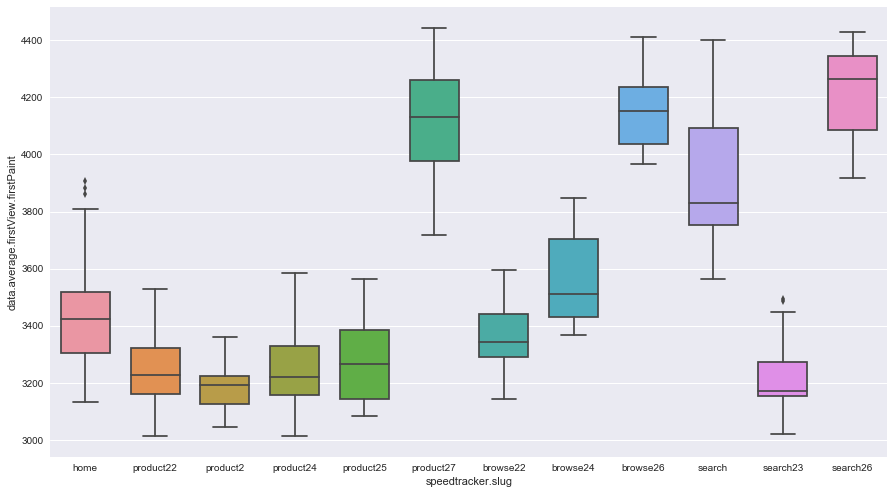

In [16]:
#
# Run to Validate Outliers for given dates and metric (use full name with dot-notation)
# Uses defined profiles from previous cell
#
# Update dates and metrics below before running
# Note: you can uncomment/comment out removing outliers below...
#

start_date = '2019/02/10'
end_date = '2019/02/23'
metric = 'data.average.firstView.firstPaint'

boxplot_collection = []

for profile_slug in speedtracker_profiles:
    _df = pd.read_csv(join(data_path, f'{profile_slug}.csv'))
    _df['date'] = pd.to_datetime(_df['data.completed'], unit='s')
    _mask = (_df['date'] > parse(start_date)) & (_df['date'] < parse(end_date)+relativedelta(days=+1))
    _dfmasked = _df[_mask]
    
    # comment next line to see data without removing outliers
    _dfmasked = remove_outlier(_dfmasked, metric)
    
    boxplot_collection.append(_dfmasked)

boxplot_df = pd.concat(boxplot_collection)
sns.set(rc={'figure.figsize':(15,8.27)})
sns.boxplot(x='speedtracker.slug', y=metric,width=.7, data=boxplot_df)